In [1]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import linprog
from scipy.optimize import minimize
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import euclidean_distances
from cautious_random_forest import CautiousRandomForest

In [2]:
class ProbabilitySetsModel:
    def __init__(self, n_trees=100, alpha=0, p_dist_type='SE', min_samples_leaf=3, random_state=42):
        self.n_trees = n_trees
        self.alpha = alpha
        self.p_dist_type = p_dist_type
        self.min_samples_leaf = min_samples_leaf
        self.classes = None
        self.n_class = None
        self.rf = RandomForestClassifier(n_estimators=n_trees, min_samples_leaf=min_samples_leaf, random_state=random_state)
        
        
    def fit(self, train_x, train_y):
        self.rf.fit(train_x, train_y)
        
        self.classes = self.rf.classes_
        self.n_class = len(self.rf.classes_)
    
    
    def predict(self, X, prediction_type='Maximality'):
        if X.ndim == 1:
            X = X.reshape(1, -1)
        n_instance = X.shape[0]
        all_probability_sets = np.zeros((n_instance, self.n_trees, self.n_class))
        for t in range(self.n_trees):
            tree = self.rf.estimators_[t]
            all_probability_sets[:,t,:] = tree.predict_proba(X)
            
        predictions = []
        n_equal = 0
        class2check = 0
        for i in range(n_instance):
            probability_set = all_probability_sets[i,:,:]
            
            if self.p_dist_type == 'L1':
                def L1_distance(p_star, probability_set):
                    total_distance = 0
                    total_distance = np.sum(np.abs(probability_set - p_star))
#                     for p_point in probability_set:
#                         dist_distance = np.sum(np.abs(p_point - p_star))
#                         total_distance += dist_distance
                    return total_distance

                constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                               {'type': 'ineq', 'fun': lambda x: x}]

                result = minimize(L1_distance, np.ones(self.n_class)/self.n_class, 
                                  args=(probability_set,), constraints=constraints)
               
#                 p_star = result.x.round(8)
                p_star = result.x
                probability_set = np.concatenate([p_star.reshape((1,-1)), probability_set])
                dists_to_p_star = abs(probability_set - p_star.reshape((1,-1))).sum(axis=1)
                    
            elif self.p_dist_type == 'KL':
                def KL_divergence(p_star, probability_set):
                    epsilon = 1e-10
                    total_distance = 0
                    p_star = np.where(p_star < epsilon, epsilon, p_star)
                    probability_set = np.where(probability_set < epsilon, epsilon, probability_set)
                    total_distance = np.sum(probability_set * np.log(probability_set/p_star))
#                     for p_point in probability_set:
#                         p_point = np.where(p_point < epsilon, epsilon, p_point)
#                         dist_distance = np.sum(p_point * np.log(p_point/p_star))
#                         total_distance += dist_distance
                    return total_distance
                
                constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                               {'type': 'ineq', 'fun': lambda x: x}]

                result = minimize(KL_divergence, np.ones(self.n_class)/self.n_class, 
                                  args=(probability_set,), constraints=constraints)
                
#                 p_star = result.x.round(5)
                p_star = result.x
                epsilon = 1e-10
                p_star = np.where(p_star < epsilon, epsilon, p_star)
                probability_set = np.where(probability_set < epsilon, epsilon, probability_set)
                probability_set = np.concatenate([p_star.reshape((1,-1)), probability_set])
                dists_to_p_star = (probability_set*np.log(probability_set/(p_star.reshape((1,-1))))).sum(axis=1)
            else: # SE
                p_star = probability_set.mean(axis=0)
                probability_set = np.concatenate([p_star.reshape((1,-1)), probability_set])
                dists_to_p_star = euclidean_distances(p_star.reshape((1,-1)), probability_set)[0]
            
            if prediction_type=='precise':
                predictions.append([self.classes[p_star.argmax()]])
            else: # imprecise predictions
                probability_set = probability_set[np.argsort(dists_to_p_star),:]
                rest_probability_set = probability_set[0:int((1-self.alpha)*self.n_trees)+1, :]
#                 rest_probability_set = np.vstack((rest_probability_set, p_star))
#                 print(rest_probability_set.shape)
#                 print(p_star)
#                 print(rest_probability_set)
                
                if prediction_type=='Maximality':
                    prediction_M_indicator = np.ones(self.n_class)
                    
                    for j in range(self.n_class):
                        compared_classes = np.setdiff1d(range(self.n_class), [j])
                        for k in compared_classes:
                            if np.all(rest_probability_set[:,j] <= rest_probability_set[:,k]):
                                prediction_M_indicator[j] = -1
                    prediction_M_index = np.where(prediction_M_indicator==1)[0]
                    predictions.append(self.classes[prediction_M_index])
                else: # E-Admissibility
                    prediction_E_indicator = np.zeros(self.n_class)
                    prediction_M_indicator = np.ones(self.n_class)
                    for j in range(self.n_class):
                        compared_classes = np.setdiff1d(range(self.n_class), [j])
                        for k in compared_classes:
                            if np.all(rest_probability_set[:,j] <= rest_probability_set[:,k]):
                                prediction_M_indicator[j] = -1
                                prediction_E_indicator[j] = -1
                                break
                        if prediction_E_indicator[j] == -1:
                            continue
                        if rest_probability_set[:,j].max() < 1/self.n_class:
                            prediction_E_indicator[j] = -1
                            continue
                        if rest_probability_set[:,j].max() > 0.5:
                            prediction_E_indicator[j] = 1
                            continue
                        if np.any(np.sum(rest_probability_set[:,j].reshape((-1,1)) > rest_probability_set, axis=1)==self.n_class-1):
                            prediction_E_indicator[j] = 1
                            
                    classes2check = np.where(prediction_E_indicator==0)[0]
                    if len(classes2check) == 0:
                        prediction_E_index = np.where(prediction_E_indicator==1)[0]
                    else:
                        for j in classes2check:
#                             k = np.setdiff1d(class2check, [j])[0]
                            def check_E_admissibility(distributions, class2check):
                                n_distributions = len(distributions)  # number of distributions
                                K = len(distributions[0])  # number of class

                                # to maximize the probability of the class to check
                                c = -distributions[:, class2check]

                                # inequality constraint matrix
                                A_ub = np.zeros((K, n_distributions))
                                for k in range(K):
                                    A_ub[k, :] = distributions[:, k] - distributions[:, class2check]
                                b_ub = np.zeros(K)

                                # Equality constraints (all weights sum to 1)
                                A_eq = np.ones(n_distributions)
                                b_eq = 1

                                # weight bounds
                                bounds = [(0, 1)] * n_distributions

                                # Solve linear programming problems
                                result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=[A_eq], b_eq=[b_eq], bounds=bounds)

                                if result.success:
                                    weighted_average = result.x
                                    return weighted_average
                                else:
                                    return None
                            
                            result = check_E_admissibility(rest_probability_set, j)

                            if result is not None:
                                prediction_E_indicator[j] = 1
                            else:
                                prediction_E_indicator[j] = -1

                    if np.all(prediction_E_indicator == prediction_M_indicator):
                        n_equal += 1
                    class2check += np.sum(prediction_E_indicator==0)
                    # here for prediction_E_indicator==0, have to sovle the LPs
                    prediction_E_index = np.where(prediction_E_indicator==1)[0]
                    predictions.append(self.classes[prediction_E_index])

#         print(n_instance, n_equal, class2check)                
        return predictions
    
        
        
    def evaluate(self, X_test, y_test, prediction_type='Maximality'):
        predictions = self.predict(X_test, prediction_type)
        precise_predictions = self.rf.predict(X_test)
        rf_acc = sum(precise_predictions==y_test)/len(y_test)
        determinacy = 0
        single_set_accuracy = 0
        set_accuracy = 0
        set_size = 0
        u65 = 0
        u80 = 0
        rf_abstention_acc = 0
        for i in range(len(y_test)):
            prediction = predictions[i]
            precise_prediction = precise_predictions[i]
            if len(prediction) == 1:
                determinacy += 1
                if prediction[0] == y_test[i]:
                    single_set_accuracy += 1
                    u65 += 1
                    u80 += 1
            else:
                set_size += len(prediction)
                if y_test[i] in prediction:
                    set_accuracy += 1
                    u65 += (-0.6/(len(prediction)**2) + 1.6/len(prediction))
                    u80 += (-1.2/(len(prediction)**2) + 2.2/len(prediction))
                if y_test[i] == precise_prediction:
                    rf_abstention_acc += 1
                    
        n_determinate = determinacy
        n_indeterminate = len(y_test) - determinacy
        
        determinacy /= len(y_test)
        if n_determinate == 0:
            single_set_accuracy = None
        else:
            single_set_accuracy /= n_determinate
            
        if n_indeterminate == 0:
            set_accuracy = None
            set_size = None
            rf_abstention_acc = None
        else:
            set_accuracy /= n_indeterminate
            set_size /= n_indeterminate
            rf_abstention_acc /= n_indeterminate
            
        u65 /= len(y_test)
        u80 /= len(y_test)
                
        return {'rf accuracy': rf_acc,
                 'determinacy': determinacy,
                 'single accuracy': single_set_accuracy,
                 'set accuracy': set_accuracy,
                 'set size': set_size,
                 'u65 score': u65, 
                 'u80 score': u80,
                 'rf abstention accuracy': rf_abstention_acc}

In [8]:
data = pd.read_csv("data/libras.csv")
X = np.array(data.iloc[:,:-1])
y = np.array(data.iloc[:,-1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=None)

In [21]:
clf = ProbabilitySetsModel(n_trees=100, alpha=0.2, p_dist_type='SQE',random_state=None)
clf.fit(X_train, y_train)

In [22]:
dist_types = ['SQE','L1','KL'] #, 'L1', 'KL'
for d_type in dist_types:
    print(d_type)
    clf.p_dist_type = d_type
    print(clf.evaluate(X_test, y_test, 'Maximality'))
    print(clf.evaluate(X_test, y_test, 'EAD'))

SQE
{'rf accuracy': 0.7647058823529411, 'determinacy': 0.08403361344537816, 'single accuracy': 0.9, 'set accuracy': 1.0, 'set size': 9.935779816513762, 'u65 score': 0.23795521258305125, 'u80 score': 0.29282343745726586, 'rf abstention accuracy': 0.7522935779816514}
{'rf accuracy': 0.7647058823529411, 'determinacy': 0.08403361344537816, 'single accuracy': 0.9, 'set accuracy': 1.0, 'set size': 9.761467889908257, 'u65 score': 0.2405064946755673, 'u80 score': 0.2961692150115618, 'rf abstention accuracy': 0.7522935779816514}
L1
{'rf accuracy': 0.7647058823529411, 'determinacy': 0.058823529411764705, 'single accuracy': 0.8571428571428571, 'set accuracy': 0.9910714285714286, 'set size': 8.8125, 'u65 score': 0.24506626977594775, 'u80 score': 0.3082412515681704, 'rf abstention accuracy': 0.7589285714285714}
{'rf accuracy': 0.7647058823529411, 'determinacy': 0.058823529411764705, 'single accuracy': 0.8571428571428571, 'set accuracy': 0.9910714285714286, 'set size': 8.508928571428571, 'u65 score'

In [89]:
clf.rf.score(X_test, y_test)

0.8857142857142857

## Precise prediction

In [33]:
data_names = ['wine', 'seeds', 'glass', 'ecoli', 'dermatology', 'libras',
               'forest', 'balance_scale', 'vehicle', 'vowel', 'yeast',
               'wine_quality', 'segment', 'waveform', 'optdigits']
# data_names = ['dermatology']
n_dataset = len(data_names)
models = ['SQE', 'L1', 'KL']
n_models = len(models)
K = 10
msl = 3
precise_prediction_evaluations = np.zeros([n_dataset, K, n_models])

for d in tqdm(range(n_dataset)):
    data_name = data_names[d]
#     print(data_name)
    data = pd.read_csv('data/{}.csv'.format(data_name))
    X = np.array(data.iloc[:,:-1])
    y = np.array(data.iloc[:,-1])
    
    kf = KFold(n_splits=K, shuffle=False)
    k = -1
    for train_index, test_index in kf.split(X):
        k += 1
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = ProbabilitySetsModel(n_trees=100, alpha=0, p_dist_type='SE', min_samples_leaf=msl, random_state=42)
        clf.fit(X_train, y_train)
        
        for i in range(n_models):
            clf.p_dist_type = models[i]
            precise_prediction_evaluations[d,k,i] = round(clf.evaluate(X_test, y_test, 'precise')['single accuracy'], 4)

precise_prediction_evaluations.mean(axis=1)
np.save('results/precise prediction/precise_prediction_evaluations_raw.npy', precise_prediction_evaluations)
precise_prediction_evaluations_mean = precise_prediction_evaluations.mean(axis=1).round(4)
precise_prediction_evaluations_mean = pd.DataFrame(precise_prediction_evaluations_mean, index=data_names, columns=models)
precise_prediction_evaluations_mean.to_csv('results/precise prediction/precise_prediction_evaluations.csv', index=True)
precise_prediction_evaluations_mean.to_excel('results/precise prediction/precise_prediction_evaluations.xlsx', index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [11:02<00:00, 44.14s/it]


In [71]:
precise_prediction_evaluations.mean(axis=1)
np.save('results/precise prediction/precise_prediction_evaluations_raw.npy', precise_prediction_evaluations)
precise_prediction_evaluations_mean = precise_prediction_evaluations.mean(axis=1).round(4)
precise_prediction_evaluations_mean = pd.DataFrame(precise_prediction_evaluations_mean, index=data_names, columns=models)
precise_prediction_evaluations_mean.to_csv('results/precise prediction/precise_prediction_evaluations.csv', index=True)
precise_prediction_evaluations_mean.to_excel('results/precise prediction/precise_prediction_evaluations.xlsx', index=True)

## Imprecise prediction

In [113]:
data_names = ['wine', 'seeds', 'glass', 'ecoli', 'dermatology', 'libras',
               'forest', 'balance_scale', 'vehicle', 'vowel', 'wine_quality', 'segment'] #, 'waveform', 'yeast'
# data_names = ['yeast','wine_quality', 'segment', 'waveform',]
dist_types = ['SQE', 'L1', 'KL']
prediction_types = ['Maximality', 'E-admissibility']
nt = 100
msl = 3
alpha_list = np.arange(0,20)/20
K = 10
total_evaluations = np.zeros((8, len(data_names), 2+len(dist_types)*len(prediction_types))) # n_metrics, n_data, n_models


for d in range(len(data_names)):
    data_name = data_names[d]
    print(data_name)
    data = pd.read_csv('data/{}.csv'.format(data_name))
    X = np.array(data.iloc[:,:-1])
    y = np.array(data.iloc[:,-1])
    
    data_evaluations = np.zeros((K,8, 2+len(dist_types)*len(prediction_types))) # n_fold, n_metrics,n_models 
    kf = KFold(n_splits=K, shuffle=False)
    k = -1
    for train_index, test_index in tqdm(kf.split(X)):
        k += 1
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # NDC and CDM_Vote
        clf = CautiousRandomForest(n_trees=nt, s=2, min_samples_leaf=msl,combination='ndc', random_state=42)
        clf.fit(X_train, y_train)
        data_evaluations[k,:,0] = np.array(list(clf.score(X_test, y_test).values()))
        clf.combination = 'cdm-vote'
        data_evaluations[k,:,1] = np.array(list(clf.score(X_test, y_test).values()))
        
        inner_kf = KFold(n_splits=K, shuffle=False)
        for i in range(len(dist_types)):
            for j in range(len(prediction_types)):
                dist_type = dist_types[i]
                prediction_type = prediction_types[j]
                index = 2 + i * len(prediction_types) + j
                
                inner_u65_evaluations = np.zeros(len(alpha_list))

                for inner_train_index, inner_val_index in inner_kf.split(X_train):
                    inner_X_train, inner_X_val = X_train[inner_train_index], X_train[inner_val_index]
                    inner_y_train, inner_y_val = y_train[inner_train_index], y_train[inner_val_index]

                    clf = ProbabilitySetsModel(n_trees=nt, alpha=0, p_dist_type=dist_type, min_samples_leaf=msl, random_state=42)
                    clf.fit(inner_X_train, inner_y_train)

                    for a in range(len(alpha_list)):
                        clf.alpha = alpha_list[a]
                        inner_u65_evaluations[a] += clf.evaluate(inner_X_val, inner_y_val, prediction_type)['u65 score']
        
                best_alpha = alpha_list[np.argmax(inner_u65_evaluations)]
                clf = ProbabilitySetsModel(n_trees=nt, alpha=best_alpha, p_dist_type=dist_type, min_samples_leaf=msl, random_state=42)
                clf.fit(X_train, y_train)
                data_evaluations[k,:,index] = np.array(list(clf.evaluate(X_test, y_test).values()))
    
    np.save('results/imprecise prediction/{}_evaluations.npy'.format(data_name), data_evaluations)           
    for i in range(8):
        for j in range(2+len(dist_types)*len(prediction_types)):
            valid_index = ~np.isnan(data_evaluations[:,i,j])
            total_evaluations[i,d,j] = data_evaluations[valid_index,i,j].mean()
#     np.save('results/imprecise prediction/total_evaluations.npy', total_evaluations)
    print(total_evaluations[:,d,:])

wine


10it [22:47, 136.79s/it]


[[0.97745098 0.97745098 0.97745098 0.97745098 0.97745098 0.97745098
  0.97745098 0.97745098]
 [0.95522876 0.93856209 0.98888889 0.98888889 0.99444444 0.99444444
  0.98888889 0.98888889]
 [0.98856209 0.99444444 0.98300654 0.98300654 0.97745098 0.97745098
  0.98300654 0.98300654]
 [1.         1.         1.         1.         1.         1.
  1.         1.        ]
 [2.         2.14285714 2.         2.         2.         2.
  2.         2.        ]
 [0.97321895 0.97186275 0.97911765 0.97911765 0.97550654 0.97550654
  0.97911765 0.97911765]
 [0.97993464 0.98098039 0.98078431 0.98078431 0.97633987 0.97633987
  0.98078431 0.98078431]
 [0.78571429 0.75       0.5        0.5        1.         1.
  0.5        0.5       ]]
seeds


10it [19:38, 117.83s/it]


[[0.91904762 0.91904762 0.91904762 0.91904762 0.91904762 0.91904762
  0.91904762 0.91904762]
 [0.91904762 0.85238095 0.92857143 0.92857143 0.93333333 0.93333333
  0.9        0.9       ]
 [0.93942356 0.9496388  0.9402381  0.9402381  0.9366416  0.9366416
  0.9379972  0.9379972 ]
 [1.         1.         1.         1.         1.         1.
  1.         1.        ]
 [2.         2.         2.         2.         2.         2.
  2.         2.        ]
 [0.91452381 0.90547619 0.91785714 0.91785714 0.9147619  0.9147619
  0.90785714 0.90785714]
 [0.92666667 0.92761905 0.92857143 0.92857143 0.9247619  0.9247619
  0.92285714 0.92285714]
 [0.68333333 0.62083333 0.52777778 0.52777778 0.66666667 0.66666667
  0.59863946 0.59863946]]
glass


10it [47:30, 285.04s/it]


[[0.77077922 0.77077922 0.77077922 0.77077922 0.77077922 0.77077922
  0.77077922 0.77077922]
 [0.7012987  0.65454545 0.8038961  0.8038961  0.86883117 0.86883117
  0.77575758 0.77575758]
 [0.87901388 0.86874237 0.84058197 0.84058197 0.81623016 0.81623016
  0.79351697 0.79351697]
 [0.89892857 0.94404762 0.88888889 0.88888889 0.83333333 0.83333333
  0.9172619  0.9172619 ]
 [2.08095238 2.24301948 2.48941799 2.48941799 2.23035714 2.23035714
  2.34952381 2.34952381]
 [0.78707431 0.7696176  0.77621461 0.77621461 0.78099206 0.78099206
  0.72774701 0.72774701]
 [0.82670996 0.81744589 0.80176905 0.80176905 0.79896104 0.79896104
  0.75636342 0.75636342]
 [0.50404762 0.57465729 0.51719577 0.51719577 0.48928571 0.48928571
  0.71130952 0.71130952]]
ecoli


10it [1:21:55, 491.57s/it]


[[0.88101604 0.88101604 0.88101604 0.88101604 0.88101604 0.88101604
  0.88101604 0.88101604]
 [0.83030303 0.77094474 0.95240642 0.95240642 0.95802139 0.95802139
  0.82780749 0.82780749]
 [0.91571559 0.93176083 0.88386152 0.88386152 0.88103253 0.88103253
  0.86931976 0.86931976]
 [0.94404762 0.92626263 0.92592593 0.92592593 1.         1.
  0.96       0.96      ]
 [2.03928571 2.08484848 2.51851852 2.51851852 2.33333333 2.33333333
  2.45666667 2.45666667]
 [0.86509061 0.85523767 0.86508033 0.86508033 0.87082108 0.87082108
  0.81642872 0.81642872]
 [0.88910873 0.88673797 0.87086774 0.87086774 0.87695856 0.87695856
  0.8398127  0.8398127 ]
 [0.710671   0.71652958 0.87037037 0.87037037 0.83333333 0.83333333
  0.84833333 0.84833333]]
dermatology


10it [1:00:25, 362.53s/it]


[[0.97492063 0.97492063 0.97492063 0.97492063 0.97492063 0.97492063
  0.97492063 0.97492063]
 [0.92460317 0.90222222 0.96936508 0.96936508 0.96936508 0.96936508
  0.91619048 0.91619048]
 [0.996875   1.         0.98268908 0.98268908 0.98013963 0.98013963
  0.97830562 0.97830562]
 [1.         1.         1.         1.         1.         1.
  1.         1.        ]
 [2.         2.07261905 2.5        2.5        2.10666667 2.10666667
  2.41111111 2.41111111]
 [0.97075397 0.96425    0.97142063 0.97142063 0.96873545 0.96873545
  0.94384934 0.94384934]
 [0.98206349 0.97877778 0.97583069 0.97583069 0.9732381  0.9732381
  0.95556905 0.95556905]
 [0.67166667 0.69071429 0.6875     0.6875     0.49333333 0.49333333
  0.89814815 0.89814815]]
libras


10it [2:57:57, 1067.74s/it]


[[0.78888889 0.78888889 0.78888889 0.78888889 0.78888889 0.78888889
  0.78888889 0.78888889]
 [0.65833333 0.64444444 0.77222222 0.77222222 0.85277778 0.85555556
  0.73055556 0.73055556]
 [0.93279808 0.91326239 0.86650071 0.86650071 0.84574806 0.84242294
  0.88883152 0.88883152]
 [0.85513736 0.89613553 0.90147436 0.90147436 0.99090909 0.99090909
  0.82207348 0.82207348]
 [2.10010684 2.34810897 2.52636752 2.52636752 2.39024892 2.33489177
  2.359889   2.359889  ]
 [0.79660926 0.77562639 0.78291759 0.78291759 0.80104213 0.80107685
  0.77408611 0.77408611]
 [0.83942222 0.82111389 0.81148333 0.81148333 0.82166759 0.82150556
  0.80456111 0.80456111]
 [0.52330739 0.56788919 0.55059829 0.55059829 0.53219697 0.54112554
  0.55851954 0.55851954]]
forest


10it [1:06:23, 398.32s/it]


[[0.88904209 0.88904209 0.88904209 0.88904209 0.88904209 0.88904209
  0.88904209 0.88904209]
 [0.9158926  0.88711901 0.97510885 0.97510885 0.98280116 0.98280116
  0.94651669 0.93113208]
 [0.91661994 0.92472011 0.89965459 0.89965459 0.89884809 0.89884809
  0.90473154 0.90435059]
 [0.93       0.96210317 0.93333333 0.93333333 0.83333333 0.83333333
  0.86666667 0.86666667]
 [2.         2.04761905 2.         2.         2.         2.
  2.40833333 2.32833333]
 [0.89023948 0.88888531 0.89243287 0.89243287 0.8932021  0.8932021
  0.88568139 0.88029678]
 [0.90199565 0.90485396 0.89587808 0.89587808 0.89549347 0.89549347
  0.89278574 0.88970882]
 [0.54047619 0.59392857 0.32666667 0.32666667 0.33333333 0.33333333
  0.53333333 0.57333333]]
balance_scale


10it [1:02:21, 374.13s/it]


[[0.8719406  0.8719406  0.8719406  0.8719406  0.8719406  0.8719406
  0.8719406  0.8719406 ]
 [0.78730159 0.73294931 0.93108039 0.93108039 0.91367127 0.91367127
  0.90729647 0.90729647]
 [0.98336361 0.99120773 0.9076182  0.9076182  0.92156666 0.92156666
  0.91534163 0.91534163]
 [0.65772796 0.80224015 0.62214286 0.62214286 0.49868132 0.49868132
  0.5815873  0.5815873 ]
 [2.08914713 2.68807639 2.06285714 2.06285714 2.14395604 2.14395604
  2.04027778 2.04027778]
 [0.86133598 0.83132104 0.86958227 0.86958227 0.87163893 0.87163893
  0.86689025 0.86689025]
 [0.88188428 0.86018433 0.87548899 0.87548899 0.87902202 0.87902202
  0.87544291 0.87544291]
 [0.46102153 0.54626503 0.47571429 0.47571429 0.26313187 0.26313187
  0.4084127  0.4084127 ]]
vehicle


10it [2:00:26, 722.62s/it]


[[0.74357143 0.74357143 0.74357143 0.74357143 0.74357143 0.74357143
  0.74357143 0.74357143]
 [0.64770308 0.5862605  0.60637255 0.59578431 0.71743697 0.71743697
  0.55656863 0.55656863]
 [0.90235004 0.92938001 0.90053044 0.90497488 0.8605127  0.8605127
  0.91625799 0.91625799]
 [0.92525598 0.9947832  0.99188034 0.99188034 0.99059829 0.99059829
  0.98206138 0.98206138]
 [2.07944323 2.29996553 2.42165037 2.42898908 2.28360375 2.28360375
  2.42643794 2.42643794]
 [0.79090103 0.79178536 0.77071218 0.76921218 0.78355258 0.78355258
  0.75650198 0.75650198]
 [0.83938375 0.8512458  0.82643137 0.82637255 0.8241348  0.8241348
  0.81865056 0.81865056]
 [0.44637663 0.47405627 0.49727506 0.49921055 0.43605793 0.43605793
  0.52373196 0.52373196]]
vowel


10it [5:48:10, 2089.01s/it]


[[0.92626263 0.92626263 0.92626263 0.92626263 0.92626263 0.92626263
  0.92626263 0.92626263]
 [0.77777778 0.72525253 0.88383838 0.88383838 0.94545455 0.94545455
  0.84444444 0.84444444]
 [0.99102071 0.99313316 0.95752636 0.95752636 0.95222357 0.95222357
  0.9604107  0.9604107 ]
 [0.96172263 0.97853848 0.9622644  0.9622644  0.91571429 0.91571429
  0.96497436 0.96497436]
 [2.04815883 2.2047925  2.18399684 2.18399684 2.15761905 2.15761905
  2.19162637 2.19162637]
 [0.90739057 0.88523586 0.91477273 0.91477273 0.93088822 0.93088822
  0.90286195 0.90286195]
 [0.93919192 0.92456263 0.93106061 0.93106061 0.93817374 0.93817374
  0.92474747 0.92474747]
 [0.70138685 0.75014549 0.68125957 0.68125957 0.45880952 0.45880952
  0.74390904 0.74390904]]
wine_quality


10it [5:41:14, 2047.48s/it]


[[0.68544811 0.68544811 0.68544811 0.68544811 0.68544811 0.68544811
  0.68544811 0.68544811]
 [0.60915094 0.50470126 0.75792846 0.75792846 0.75668632 0.75668632
  0.67732311 0.67732311]
 [0.78034479 0.80197882 0.74503964 0.74503964 0.74588401 0.74588401
  0.75075169 0.75075169]
 [0.90021345 0.90720211 0.89039474 0.89039474 0.89122266 0.89122266
  0.86540814 0.86540814]
 [2.01825123 2.09383299 2.11791917 2.11791917 2.11503365 2.11503365
  2.24335751 2.24335751]
 [0.70279638 0.6888019  0.69525007 0.69525007 0.6998259  0.6998259
  0.67491676 0.67491676]
 [0.7554827  0.75547494 0.72684906 0.72684906 0.73182488 0.73182488
  0.71555732 0.71555732]
 [0.53770633 0.56725248 0.49985025 0.49985025 0.50753071 0.50753071
  0.53578499 0.53578499]]
segment


10it [3:49:37, 1377.79s/it]

[[0.97619048 0.97619048 0.97619048 0.97619048 0.97619048 0.97619048
  0.97619048 0.97619048]
 [0.95584416 0.94069264 0.98051948 0.98051948 0.97705628 0.97705628
  0.94718615 0.94718615]
 [0.99278016 0.99585346 0.98633489 0.98633489 0.98503059 0.98503059
  0.98488775 0.98488775]
 [0.92349456 0.93463602 0.92571429 0.92571429 0.940625   0.940625
  0.90358804 0.90358804]
 [2.02222222 2.061237   2.1352381  2.1352381  2.18125    2.18125
  2.43109845 2.43109845]
 [0.97549062 0.97253968 0.97823954 0.97823954 0.97564755 0.97564755
  0.96107864 0.96107864]
 [0.98164502 0.9808658  0.9808658  0.9808658  0.97882035 0.97882035
  0.96804473 0.96804473]
 [0.5937696  0.6450189  0.38904762 0.38904762 0.58125    0.58125
  0.77455703 0.77455703]]


In [3]:
total_evaluations = np.load('results/imprecise prediction/total_evaluations.npy')

In [7]:
sheet_names = ['RF Acc', 'Determinacy', 'Single Acc', 'Set Acc', 'Set Size', 'U65', 'U80', 'RF Abstention Acc']
data_names = ['wine', 'seeds', 'glass', 'ecoli', 'dermatology', 'libras', 'forest', 'balance_scale', 'vehicle', 'vowel', 'wine_quality', 'segment']
model_names = ['NDC', 'CRF', 'SQE-Max', 'SQE-Ead', 'L1-Max', 'L1-Ead', 'KL-Max', 'KL-Ead']

with pd.ExcelWriter('results/imprecise prediction/total_evaluations.xlsx') as writer:
    for i in range(len(sheet_names)):
        sheet_name = sheet_names[i]
        df = pd.DataFrame(total_evaluations[i].round(4), columns=model_names, index=data_names)
        df.to_excel(writer, sheet_name=sheet_name, index=True)


    

In [124]:
total_evaluations[-2]

array([[0.97993464, 0.98098039, 0.98078431, 0.98078431, 0.97633987,
        0.97633987, 0.98078431, 0.98078431],
       [0.92666667, 0.92761905, 0.92857143, 0.92857143, 0.9247619 ,
        0.9247619 , 0.92285714, 0.92285714],
       [0.82670996, 0.81744589, 0.80176905, 0.80176905, 0.79896104,
        0.79896104, 0.75636342, 0.75636342],
       [0.88910873, 0.88673797, 0.87086774, 0.87086774, 0.87695856,
        0.87695856, 0.8398127 , 0.8398127 ],
       [0.98206349, 0.97877778, 0.97583069, 0.97583069, 0.9732381 ,
        0.9732381 , 0.95556905, 0.95556905],
       [0.83942222, 0.82111389, 0.81148333, 0.81148333, 0.82166759,
        0.82150556, 0.80456111, 0.80456111],
       [0.90199565, 0.90485396, 0.89587808, 0.89587808, 0.89549347,
        0.89549347, 0.89278574, 0.88970882],
       [0.88188428, 0.86018433, 0.87548899, 0.87548899, 0.87902202,
        0.87902202, 0.87544291, 0.87544291],
       [0.83938375, 0.8512458 , 0.82643137, 0.82637255, 0.8241348 ,
        0.8241348 , 0.818650

In [ ]:
columns = ['RF Acc', 'Determinacy', 'Single Acc', 'Set Acc', 'Set Size', 'U65', 'U80', 'RF Abstention Acc', 'Abstention Corr']
data_names = ['ecoli', 'balance_scale', 'vehicle', 'vowel', 'wine_quality', 'optdigits', 'segment',  'waveform', 'letter']
df = pd.DataFrame(total_evaluations, index = data_names, columns=columns)
df.to_csv('results/total_performance_evaluations.csv')
df.to_excel('results/total_performance_evaluations.xlsx')

## Function of alpha

In [111]:
data_names = ['wine', 'seeds', 'glass', 'ecoli', 'dermatology', 'libras',
               'forest', 'balance_scale', 'vehicle', 'vowel', 'yeast',
               'wine_quality', 'segment', 'waveform', 'optdigits']
# data_names = ['libras']
alpha_list = np.arange(0,21)/20
K = 10
evaluations_with_alpha = np.zeros((len(data_names), len(alpha_list), 3))

for d in range(len(data_names)):
    data_name = data_names[d]
    print(data_name)
    data = pd.read_csv('data/{}.csv'.format(data_name))
    X = np.array(data.iloc[:,:-1])
    y = np.array(data.iloc[:,-1])

    kf = KFold(n_splits=K, shuffle=False)

    for train_index, test_index in tqdm(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = ProbabilitySetsModel(n_trees=100, alpha=0, p_dist_type='SQE', min_samples_leaf=3, random_state=42)
        clf.fit(X_train, y_train)

        for a in range(len(alpha_list)):
            clf.alpha = alpha_list[a]
            evaluations_with_alpha[d, a, 0] += clf.rf.score(X_test, y_test)
            if alpha_list[a] == 1:
                imprecise_score = clf.evaluate(X_test, y_test, 'precise')
            else:
                imprecise_score = clf.evaluate(X_test, y_test, 'Maximality')
            evaluations_with_alpha[d, a, 1] += imprecise_score['u65 score']
            evaluations_with_alpha[d, a, 2] += imprecise_score['u80 score']
            
            
#     print(evaluations_with_alpha[d]/K)
evaluations_with_alpha = evaluations_with_alpha/K
np.save('results/function of alpha/evaluations_as_function_of_alpha.npy', evaluations_with_alpha)

wine


10it [00:09,  1.01it/s]


seeds


10it [00:10,  1.08s/it]


glass


10it [00:12,  1.23s/it]


ecoli


10it [00:16,  1.60s/it]


dermatology


10it [00:14,  1.43s/it]


libras


10it [00:28,  2.83s/it]


forest


10it [00:15,  1.52s/it]


balance_scale


10it [00:14,  1.46s/it]


vehicle


10it [00:20,  2.02s/it]


vowel


10it [00:42,  4.30s/it]


yeast


10it [00:52,  5.21s/it]


wine_quality


10it [00:36,  3.69s/it]


segment


10it [00:52,  5.25s/it]


waveform


10it [01:26,  8.60s/it]


optdigits


10it [02:51, 17.18s/it]


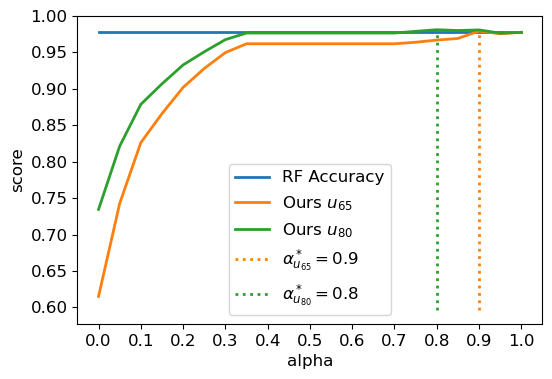

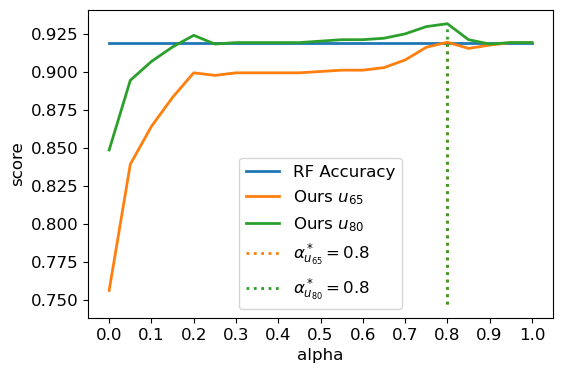

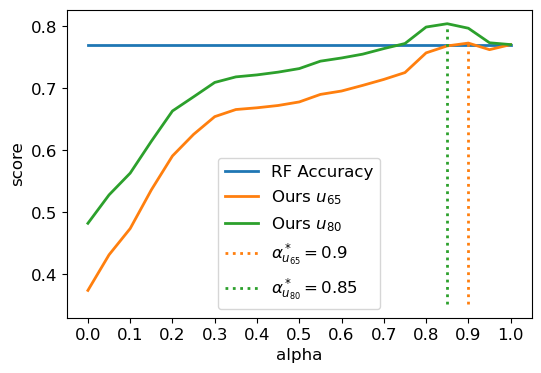

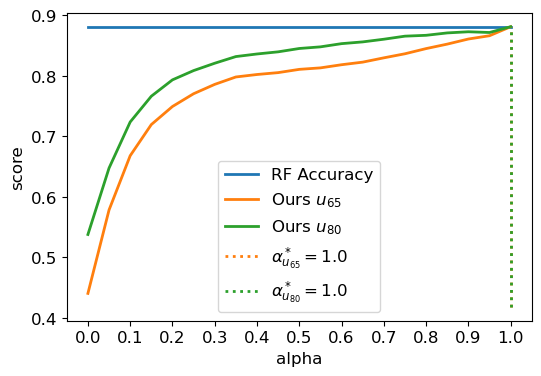

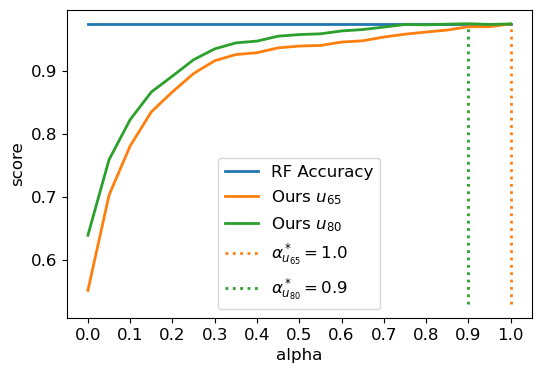

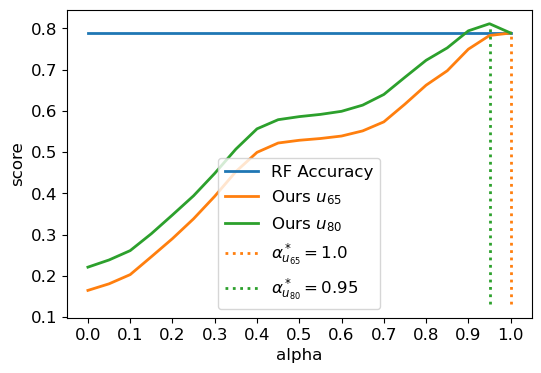

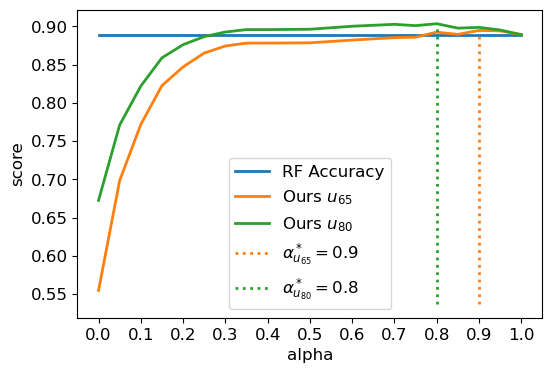

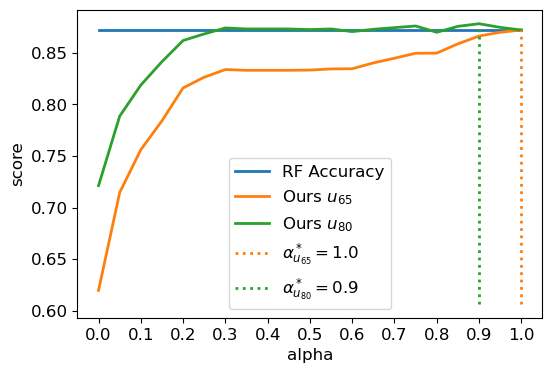

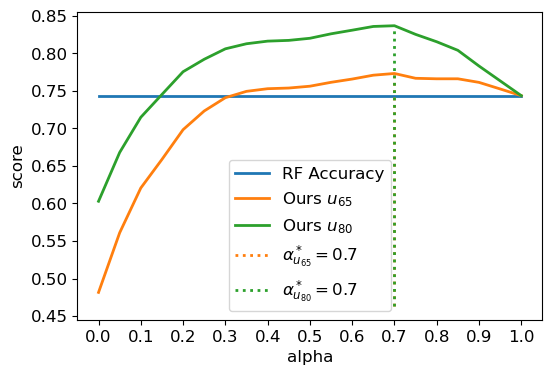

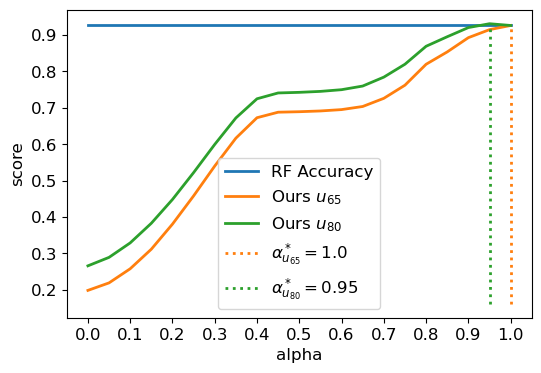

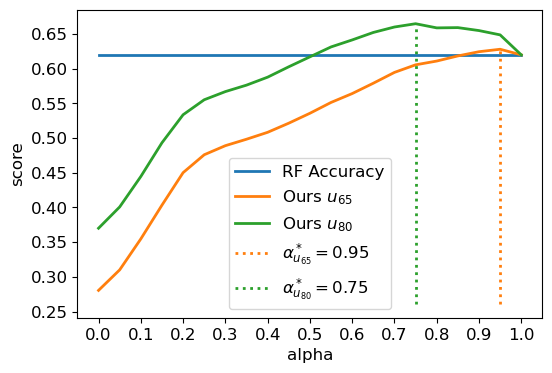

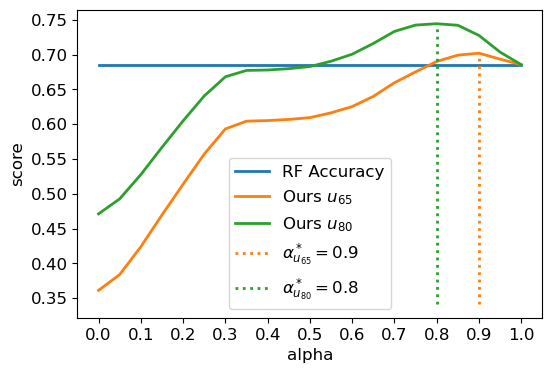

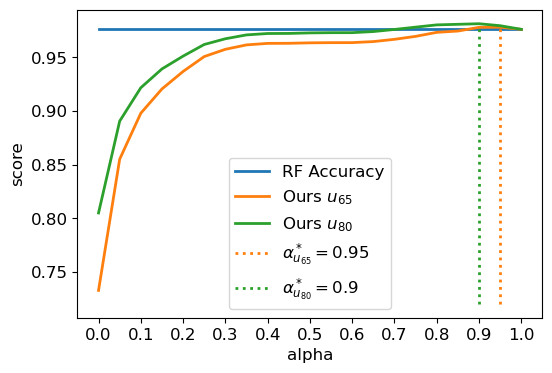

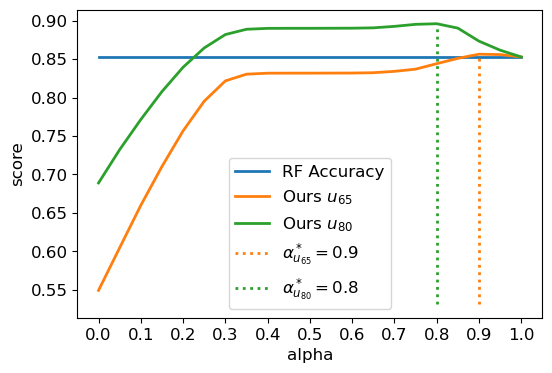

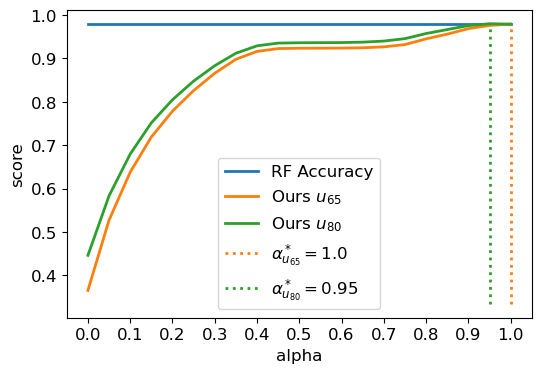

In [112]:
data_names = ['wine', 'seeds', 'glass', 'ecoli', 'dermatology', 'libras',
               'forest', 'balance_scale', 'vehicle', 'vowel', 'yeast',
               'wine_quality', 'segment', 'waveform', 'optdigits']
# data_names = ['libras']
for d in range(len(data_names)):
    evaluation = evaluations_with_alpha[d,:,:]
    u65_best_alpha = alpha_list[np.argmax(evaluation[:,1])]
    best_u65 = evaluation[:,1].max()
    u80_best_alpha = alpha_list[np.argmax(evaluation[:,2])]
    best_u80 = evaluation[:,2].max()
    
    fig = plt.figure(figsize=(6,4))
    
    plt.plot(alpha_list, evaluation[:,0], linewidth=2, color='tab:blue', label='RF Accuracy')
    plt.plot(alpha_list, evaluation[:,1], linewidth=2, color='tab:orange', label='Ours $u_{65}$')
    plt.plot(alpha_list, evaluation[:,2], linewidth=2, color='tab:green', label='Ours $u_{80}$')
    
    bottom = plt.ylim()[0]
    plt.plot([u65_best_alpha, u65_best_alpha], [bottom, best_u65], linewidth=2, 
             alpha=1, linestyle=':', color='tab:orange', label=r'$\alpha^*_{u_{65}}=$'+str(u65_best_alpha))
    plt.plot([u80_best_alpha, u80_best_alpha], [bottom, best_u80], linewidth=2, 
             alpha=1, linestyle=':', color='tab:green', label=r'$\alpha^*_{u_{80}}=$'+str(u80_best_alpha))
    
    plt.xlabel('alpha', fontsize=12)
    plt.ylabel('score', fontsize=12)
    plt.xticks(alpha_list[::2], fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12) #, bbox_to_anchor=(0.2, 0.1, 0.8, 0.5)
    
    plt.savefig('results/function of alpha/{}_plot.png'.format(data_names[d]), bbox_inches='tight', dpi=600)
    plt.show()
    plt.close()